# Assignment 1: Supervised learning, Linear models, and Loss functions

In this assignment, you're going to write your own methods to fit a linear model using either an OLS or LAD cost function.  

## Data set

We will examine some data representing the miles-per-gallon of 398 cars given other variables describing them:

1. mpg: continuous. The miles-per-gallon of the car.
2. cylinders: multi-valued discrete. Number of cylinders.
3. displacement: continuous. Engine displacement of the car.
4. horsepower: continuous. Total horsepower of the car.
5. weight: continuous. Weight in lbs.
6. acceleration: continuous. Acceleration 0-60mph in seconds.
9. car name: string (unique for each instance, DO NOT USE)

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.


## Preliminaries

In [9]:
# Import all the necessary packages:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import scipy.optimize as so
from sklearn import linear_model
from sklearn.metrics import r2_score

%matplotlib inline

In [10]:
# Uncomment if using Google Colab or Kaggle Kernels.
# Imports the data using gdown.
# !gdown https://drive.google.com/uc?id=1PtY3ne37XA8Jk_cAf0Cd7JSRvEU8KDbp


## Part 1
### Question 1.1:


Read the `car_data.csv` file as a `pandas.DataFrame` and show its descriptive statistics.  Investigate the relationship between the cars' weight and their mpg by plotting a scatter plot of the `weight` (x axis) and `mpg` columns (y axis). Add an `alpha` (transparency of the plotted dots) in case some data are overlapping. Remember to label your axes.

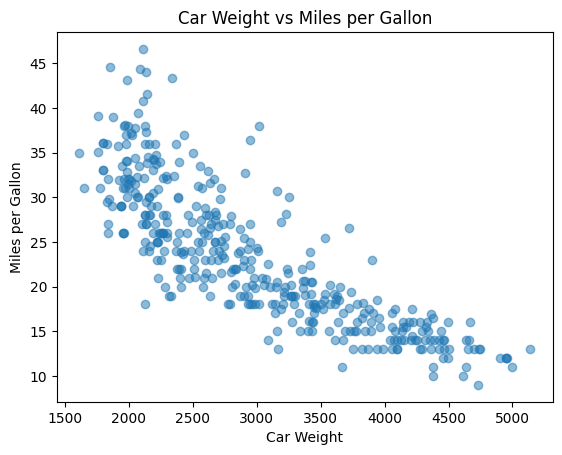

In [11]:
# YOUR CODE HERE

df = pd.read_csv('car_data.csv')
df.describe(include="all")

x = np.array(df["weight"])
y = np.array(df["MPG"])

plt.scatter(x, y, alpha=0.5)
plt.xlabel("Car Weight")
plt.ylabel("Miles per Gallon")
plt.title("Car Weight vs Miles per Gallon")
plt.show()

**Written answer: What do you see here? Discuss your findings**

I see that there is the possibility that there is a linear relationship between car weight and miles per gallon. The scatter plot appears to be curved, but the coefficients appear to be able to be written in a linear fashion. 

### Question 1.2: point

Recall that the linear model, we obtain predictions by computing

$$ \hat{\mathbf{y}} = \mathbf{X} \hat{\beta} $$

Here, $\mathbf{X}$ is a design matrix which includes a column of ones, $\hat{\beta}$ are coefficients, and $\hat{\mathbf{y}}$ are outcomes.  Write a function `linearModelPredict` to compute linear model predictions given data and a coefficient vector.  The function should take as it's arguments a 1d-array of coefficients `b` and the design matrix `X` as a 2d-array and return linear model predictions `yp`.

Test the function by setting

```
X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
```

Call your function using these values.

Report $\hat{\mathbf{y}}$. Print the dimensionality of the numpy-array that you get.

Hint:  Read the documentation for `np.dot` or the `@` operator in `numpy`.

In [12]:
# Your code here.

def linearModelPredict(b,X):
    if len(b.shape) == 1:
        b = b.reshape(-1,1)
    if len(X.shape) == 1:
        X = X.reshape(-1,1)
    if b.shape[0] != X.shape[1]:
        raise Exception(f"Number of columns in b ({b.shape[0]}) is different from number of rows in X ({X.shape[1]})")
    yp = X@b
    return yp

print(linearModelPredict(b = np.array([0.1,0.3]), X = np.array([[1,0],[1,-1],[1,2]])))
print(linearModelPredict(b = np.array([0.1,0.3]), X = np.array([[1,0],[1,-1],[1,2]])).shape)

[[ 0.1]
 [-0.2]
 [ 0.7]]
(3, 1)


### Question 1.3:

Write a function `linearModelMSE` which computes and returns the mean squared error parameterized by $\beta$, as well as the gradient of the loss.  The function should take as its first argument a 1D-array `beta` of coefficients for the linear model, as its second argument the design matrix `X` as a 2D-array, and as its third argument a 1D-array `y` of observed outcomes. Recall that:

$$
MSE(y_i, \hat{y_i}) = \frac{1}{|I|} \sum_i (y_i - \hat{y_i})^2
$$
$$
\nabla MSE(y, \hat{y}) = -\frac{2}{|I|} \left[(y-\hat{y}) \cdot X\right]
$$

Test the function with the values

```
X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
y = np.array([0,0.4,2])
```

Report the loss and the gradient.



In [96]:
# Your code here.
def linearModelMSE(beta, X, y):
    yp = X@beta
    y_pred = yp.reshape(-1,1)
    y_real = np.array(y).reshape(-1,1)
    assert y_real.shape == y_pred.shape
    MSE = np.mean((y_real - y_pred)**2)
    GradientMSE = 2*( (y_pred-y_real).T@X)/len(y_real)
    return MSE, GradientMSE

print(f"The loss and gradient are {linearModelMSE(beta = np.array([0.1,0.3]), X = np.array([[1,0],[1,-1],[1,2]]), y = np.array([0,0.4,2]))}")
    

The loss and gradient are (0.6866666666666666, array([[-1.2       , -1.33333333]]))


**Written answer**: To minimize the loss, do you need increase or decrease the value of the parameters?

**Your answer here.** To minimize the loss, we need to increase the value of the parameters

### Question 1.4:

Now that you've implemented a loss function in question 1.3, it is now time to minimize it!

Write a function `linearModelFit` to fit a linear model.  The function should take as its first argument the design matrix `X` as a 2D-array, as its second argument a 1D-array `y` of outcomes, and as its third argument a function  `lossfcn` which returns as a tuple the value of the loss, as well as the gradient of the loss. As a result, it should return the estimated betas and the $R^2$. Pass the argument `jac=True` to the `miminize` function so that it uses your gradient.

Test the function with the values:
```
X = np.array([[1,0],[1,-1],[1,2]])
y = np.array([0,0.4,2])
```

Report the best parameters and the fitted $R^2$.


In [112]:
# Your code here


X = np.array([[1,0],[1,-1],[1,2]])
y = np.array([0,0.4,2])


def linearModelFit(X, y, lossfcn):

    X = X.reshape(X.shape[0], -1)
    beta0 = np.zeros(X.shape[1],)
    print(f"shape of y is {y.shape}")
    print(f"shape of x is {X.shape}")
    print(f"shape of beta is {beta0.shape}")
    
    def lossfcn1(beta):
        MSE, GradientMSE = lossfcn(beta, X, y)
        return MSE, GradientMSE

    result = so.minimize(lossfcn1, x0=beta0, jac=True)
    beta_opt = result.x
    y_pred = X@beta_opt
    ss_total = np.sum((y - np.mean(y))**2)
    
    print(f"ss_total is {ss_total}")
    ss_residual = np.sum((y - y_pred)**2)
    
    print(f"ss_residual is {ss_residual}")
    r2 = 1 - (ss_residual / ss_total)
    return beta_opt, r2

def lossfcn(beta, X, y):
        MSE = linearModelMSE(beta, X, y)[0]
        GradientMSE = linearModelMSE(beta, X, y)[1].flatten()
        return MSE, GradientMSE

linearModelFit(X,y,lossfcn)
    

shape of y is (3,)
shape of x is (3, 2)
shape of beta is (2,)
ss_total is 2.24
ss_residual is 0.560000000021366


(array([0.59999731, 0.600001  ]), 0.7499999999904616)

### Question 1.5:

Use the above functions to fit your model to the car data. Use the MPG as the target (y) variable and only the weight variable as the independent (x). Fit the model with a constant. Then use your model and the fitted parameters to make predictions along a grid of equally spaced weights within the original range of the weight variable.  

Plot the data and add a line for the predicted values. You can get these by generating a new X-matrix with 100 equally space weights (using for example [```np.linspace```](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html)). Also report the $R^2$ value for the fit. You can do this by either printing out the $R^2$ of the fit or putting it on your plot via the `annotate` function in matplotlib.


In [113]:
# Your code here

df = pd.read_csv('car_data.csv')
weight = np.array(df["weight"])
mpg = np.array(df["MPG"])


linearModelFit(weight, mpg, lossfcn) # R squared is out of range

shape of y is (392,)
shape of x is (392, 1)
shape of beta is (1,)
ss_total is 23818.99346938776
ss_residual is 70181.58573368235


(array([0.00670886]), -1.9464547200065332)

**Your answer here**

### Question 1.6:

Now use sklearn's `linear_model` to fit the model with all the available data. Plot the data and add a line for the predicted values as you did in the previous question. Also report the $R^2$ value for the fit.

**Written answer: How much do you gain by having more variables?**

In [114]:
# Your code here

model = linear_model.LinearRegression(fit_intercept=False)
model.fit(weight,mpg)
model.coef_
model.score(weight, mpg)


ValueError: Expected 2D array, got 1D array instead:
array=[3504 3693 3436 3433 3449 4341 4354 4312 4425 3850 3563 3609 3761 3086
 2372 2833 2774 2587 2130 1835 2672 2430 2375 2234 2648 4615 4376 4382
 4732 2130 2264 2228 2634 3439 3329 3302 3288 4209 4464 4154 4096 4955
 4746 5140 2962 2408 3282 3139 2220 2123 2074 2065 1773 1613 1834 1955
 2278 2126 2254 2408 2226 4274 4385 4135 4129 3672 4633 4502 4456 4422
 2330 3892 4098 4294 4077 2933 2511 2979 2189 2395 2288 2506 2164 2100
 4100 3672 3988 4042 3777 4952 4464 4363 4237 4735 4951 3821 3121 3278
 2945 3021 2904 1950 4997 4906 4654 4499 2789 2279 2401 2379 2124 2310
 2472 2265 4082 4278 1867 2158 2582 2868 3399 2660 2807 3664 3102 2901
 3336 1950 2451 1836 2542 3781 3632 3613 4141 4699 4457 4638 4257 2219
 1963 2300 1649 2003 2125 2108 2246 2489 2391 2000 3264 3459 3432 3158
 4668 4440 4498 4657 3907 3897 3730 3785 3039 3221 3169 2171 2639 2914
 2592 2702 2223 2545 2984 1937 3211 2694 2957 2945 2671 1795 2464 2220
 2572 2255 2202 4215 4190 3962 4215 3233 3353 3012 3085 2035 2164 1937
 1795 3651 3574 3645 3193 1825 1990 2155 2565 3150 3940 3270 2930 3820
 4380 4055 3870 3755 2045 2155 1825 2300 1945 3880 4060 4140 4295 3520
 3425 3630 3525 4220 4165 4325 4335 1940 2740 2265 2755 2051 2075 1985
 2190 2815 2600 2720 1985 1800 1985 2070 1800 3365 3735 3570 3535 3155
 2965 2720 3430 3210 3380 3070 3620 3410 3425 3445 3205 4080 2155 2560
 2300 2230 2515 2745 2855 2405 2830 3140 2795 3410 1990 2135 3245 2990
 2890 3265 3360 3840 3725 3955 3830 4360 4054 3605 3940 1925 1975 1915
 2670 3530 3900 3190 3420 2200 2150 2020 2130 2670 2595 2700 2556 2144
 1968 2120 2019 2678 2870 3003 3381 2188 2711 2542 2434 2265 2110 2800
 2110 2085 2335 2950 3250 1850 2145 1845 2910 2420 2500 2290 2490 2635
 2620 2725 2385 1755 1875 1760 2065 1975 2050 1985 2215 2045 2380 2190
 2210 2350 2615 2635 3230 3160 2900 2930 3415 3725 3060 3465 2605 2640
 2395 2575 2525 2735 2865 1980 2025 1970 2125 2125 2160 2205 2245 1965
 1965 1995 2945 3015 2585 2835 2665 2370 2950 2790 2130 2295 2625 2720].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

**Your answer here.**

## Part 2: LAD Regression

### Question 2.1:

In the previous section, we worked with the squared loss.  Now, we'll implement a linear model with least absolute deviation loss $LAD(y_i, \hat{y_i})$.

$$
LAD(y_i, \hat{y_i}) = \frac{1}{|I|}\sum_i |y_i - \hat{y_i}|
$$

where $y_i$ is the true label of sample $i \in I$, $\hat{y_i}$ is the prediction, $I$ is the sample set, and $|I|$ is the number of cases in the sample. The gradient of the function is:

$$
\nabla LAD(y, \hat{y}) = - \frac{ sign(y_i - \hat{y_i}) \cdot X}{|I|}
$$

with `sign` the sign function. Note this function is undefined at 0.

Write a function `linearModelLossLAD` which computes the least absolute deviation loss function for a linear model parameterized by $\beta$, as well as the gradient of the loss, following the same structured as the previous part.

Test the function with the values

```
X = np.array([[1,0],[1,-1],[1,2]])
b = np.array([0.1,0.3])
y = np.array([0,0.4,2])
```

Report the loss and the gradient.

In [ ]:
# Your code here

### Question 2.2:


Use the above functions to fit your LAD model using the weight variable as input, to predict the mpg. Use your model to make predictions along a grid of 100 equally spaced car weights.  Once fit, add the fitted line to the scatter plot as in question 1.5.  Also report the $R^2$-value.

**Written answer**: What is the difference in the fit obtained with an $L_1$ as compared to the $L_2$ cost function? How do their $R^2$ values compare? Why?  

Note: If you receive an error from the optimizer, it may be because the loss function for the LAD model is not differentiable at its minimum.  This will lead to some gradient-based optimizers to fail to converge.  If this happens to you then pass `method="Powell"` to `scipy.optimize.minimize`.



In [ ]:
# Your code here

**Your answer here.**

### Question 2.3:

Now we will use all data for the fit. Fit an LAD model to the car data (excluding the name) with the `linear_model` module from the `sklearn` package by using the [`QuantileRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor) class that implements a [pinball loss](https://en.wikipedia.org/wiki/Quantile_regression), a more general case of the [`mean_absolute_error`](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_absolute_error.html) loss. To get an MAD regression, set the parameters `alpha=0` and `quantile=0.5` in the `QuantileRegressor` call.

In no more than two sentences, comment on the $R^2$ values for both the OLS and MAD regressions. Use the `sklearn` models for this analysis. Are they similar? Make a scatterplot of the sklearn's OLS and MAD predictions.

In [ ]:
# Your code here

**Your answer here.**